# Supervised Algorithms For The Detection Of COVID-19 From Chest CT Scan Images

### Import necessary libraries

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import plot_precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.extmath import density
from sklearn.neural_network import MLPClassifier
from imutils import paths
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import mahotas
from IPython.display import Image
from time import time
from pylab import imshow, gray, show
from os import path
import random
%matplotlib inline
print('Libraries successfully imported')

Matplotlib is building the font cache; this may take a moment.


Libraries successfully imported


### Extract the Raw Pixel Intensities

In [2]:
def image_to_feature_vector(image):
	image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert from BGR to Grayscale
	return cv2.resize(image, (60, 60)).flatten()

### Extract a 3D color histogram from the HSV colorspace to characterize the color distribution of the pixels in the images

In [3]:
def extract_color_histogram(image, bins=[8, 8, 8]):
#Extract using the supplied number of `bins` per channel,\
#then perform "in place" normalization in OpenCV, and return the flattened histogram as the feature vector
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([image], [0], None, [180], [0, 180])
    hist_s = cv2.calcHist([image], [1], None, [256], [0, 256])
    hist_v = cv2.calcHist([image], [2], None, [256], [0, 256])
    hist_h = cv2.normalize(hist_h, hist_h)
    hist_s = cv2.normalize(hist_s, hist_s)
    hist_v = cv2.normalize(hist_v, hist_v)
    return np.concatenate([hist_h, hist_s, hist_v], axis=0).reshape(-1)

### Extract the Haralick Texture features using Mahotas, and return the feature vector

In [4]:
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the Haralick Texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

### Extract the Threshold Adjacency Statistics features using Mahotas, and return the feature vector

In [5]:
def fd_tas(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the Threshold Adjacency Statistics feature vector
    value = mahotas.features.tas(gray) 
    return value

### Specify the directory for the CT scan images, and initialize the matrices

In [6]:
# grab the list of images that we'll be describing
print("[INFO] Loading images...")
imagePaths = list(paths.list_images("Images-processed/"))
rawImages = []
histogram = []
hara = []
tas = []
labels = []
features = []

[INFO] Loading images...


### Benchmark function

In [7]:
results = []
def benchmark(clf, name):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    
    print()

    score = accuracy_score(y_test, pred)
    print("Train Accuracy: %0.3f" % accuracy_score(y_train, clf.predict(X_train)))
    print("Test Accuracy: %0.3f" % score)

    print()

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))
    
    print()
    print("classification report:")
    print(classification_report(y_test, pred))

    print("confusion matrix:")
    print(confusion_matrix(y_test, pred))
    
    plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, labels=['NON_COVID', 'COVID-19']) 
    plt.show()
    
    #plot_precision_recall_curve(clf, X_test, y_test)
    #plt.show()
    
    print()
    clf_descr = name
    return clf_descr, score, train_time, test_time

### Loop over the input images:
#### 1) load the image and extract the class label (assuming that our path is in the format: /path/to/dataset/{class}.{image_num}.jpg
#### 2) extract the Raw Pixel Intensity, the Color Histogram, the Haralick Texture, and Threshold Adjacency Statistics features
#### 3) update the matricies respectively

In [8]:
start_time = time()
for (i, imagePath) in enumerate(imagePaths):

	image = cv2.imread(imagePath)
	label = imagePath.split(os.path.sep)[-1].split(".")[0]

	pixels = image_to_feature_vector(image)
	haralick = fd_haralick(image)
	tass = fd_tas(image)
	hist = extract_color_histogram(image)

	rawImages.append(pixels)
	histogram.append(hist)
	tas.append(tass)
	hara.append(haralick)
	labels.append(label)
    
	if i > 0 and i % 100 == 0:    # show an update every 100 images
		print("[INFO] Processed {}/{}".format(i, len(imagePaths)))
print("[INFO] Processed {}/{}".format(i+1, len(imagePaths)))
print("--- %s seconds ---" % (time() - start_time))


[INFO] Processed 100/2471
[INFO] Processed 200/2471
[INFO] Processed 300/2471
[INFO] Processed 400/2471
[INFO] Processed 500/2471
[INFO] Processed 600/2471
[INFO] Processed 700/2471
[INFO] Processed 800/2471
[INFO] Processed 900/2471
[INFO] Processed 1000/2471
[INFO] Processed 1100/2471
[INFO] Processed 1200/2471
[INFO] Processed 1300/2471
[INFO] Processed 1400/2471
[INFO] Processed 1500/2471
[INFO] Processed 1600/2471
[INFO] Processed 1700/2471
[INFO] Processed 1800/2471
[INFO] Processed 1900/2471
[INFO] Processed 2000/2471
[INFO] Processed 2100/2471
[INFO] Processed 2200/2471
[INFO] Processed 2300/2471
[INFO] Processed 2400/2471
[INFO] Processed 2471/2471
--- 441.59958958625793 seconds ---


### Show some information on the memory consumed each matrix

In [9]:
rawImages = np.array(rawImages)
histogram = np.array(histogram)
labels = np.array(labels)
hara = np.array(hara)
tas = np.array(tas)
features = np.concatenate((hara, tas), axis=1)
features = np.concatenate((features, histogram), axis=1)

print("[INFO] pixels matrix: {} {:.2f}MB".format(
	rawImages.shape, rawImages.nbytes / (1024 * 1000.0)))
print("[INFO] histogram matrix: {} {:.2f}MB".format(
	histogram.shape, histogram.nbytes / (1024 * 1000.0)))
print("[INFO] haralick matrix: {} {:.2f}MB".format(
    hara.shape, hara.nbytes / (1024 * 1000.0)))
print("[INFO] TAS matrix: {} {:.2f}MB".format(
    tas.shape, tas.nbytes / (1024 * 1000.0)))
print("[INFO] features matrix: {} {:.2f}MB".format(
    features.shape, features.nbytes / (1024 * 1000.0)))

[INFO] pixels matrix: (2471, 3600) 8.69MB
[INFO] histogram matrix: (2471, 692) 6.68MB
[INFO] haralick matrix: (2471, 13) 0.25MB
[INFO] TAS matrix: (2471, 54) 1.04MB
[INFO] features matrix: (2471, 759) 14.65MB


### Split partition the data into training and testing splits, using 80% of the data for training and 20% for testing, with a random state of 10

In [10]:
(trainRI, testRI, trainRL, testRL) = train_test_split(rawImages, labels, test_size=0.20, random_state=10)
(trainHara, testHara, trainHaraL, testHaraL) = train_test_split(hara, labels, test_size=0.20, random_state=10)
(trainTas, testTas, trainTasL, testTasL) = train_test_split(tas, labels, test_size=0.20, random_state=10)
(trainFeat, testFeat, trainLabels, testLabels) = train_test_split(histogram, labels, test_size=0.20, random_state=10)

(trainF, testF, trainFL, testFL) = train_test_split(features, labels, test_size=0.20, random_state=10)

In [11]:
y_train_b = trainFL.tolist()
y_test_b = testFL.tolist()

/home/amr/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Training Data')

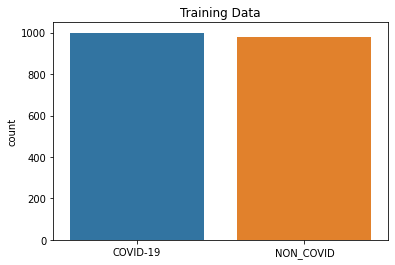

In [12]:
import seaborn as sns
sns.countplot(y_train_b, order = ['COVID-19', 'NON_COVID'])
plt.title('Training Data')

/home/amr/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Testing Data')

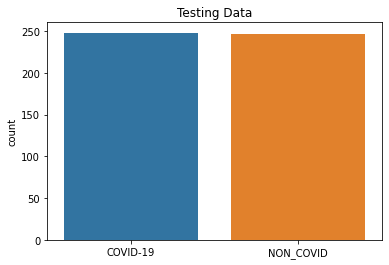

In [13]:
sns.countplot(y_test_b, order = ['COVID-19', 'NON_COVID'])
plt.title('Testing Data')

### Note:
### You can skip to the "Anvil App" section to use the app

## A. Training the algorithms using the Raw Pixel Intensities

### Show a sample of CT Scan Images

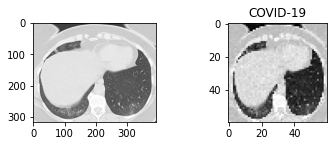

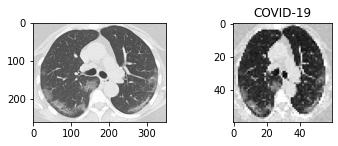

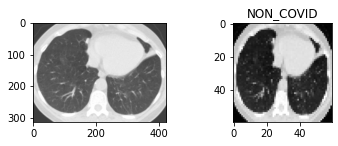

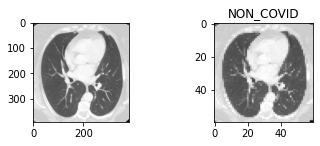

In [14]:
imagePaths = list(paths.list_images("Images-processed/"))
rand = random.choices(imagePaths, k=4)
for (i, rand) in enumerate(rand):
    img = cv2.imread(rand)
    plt.subplot(221), imshow(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (60, 60))
    label = rand.split(os.path.sep)[-1].split(".")[0]
    plt.subplot(222), imshow(img, 'gray')
    plt.title(label)
    plt.show()

### Specify the inputs

In [15]:
X = rawImages
y = labels
X_train = trainRI
X_test = testRI
y_train = trainRL
y_test = testRL

### Perform standardization by centering and scaling the training set and the test set

In [16]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Train and evaluate a k-NN classifer on the raw pixel intensities

[INFO] evaluating k-NN on raw pixel accuracy...
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=3)
train time: 0.483s
test time:  10.367s

Train Accuracy: 0.966
Test Accuracy: 0.931


classification report:
              precision    recall  f1-score   support

    COVID-19       0.93      0.93      0.93       248
   NON_COVID       0.93      0.94      0.93       247

    accuracy                           0.93       495
   macro avg       0.93      0.93      0.93       495
weighted avg       0.93      0.93      0.93       495

confusion matrix:
[[230  18]
 [ 16 231]]


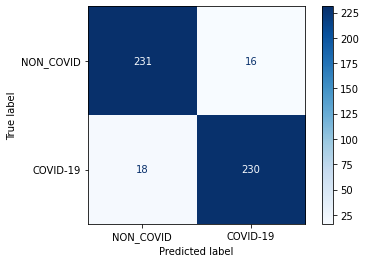

In [17]:
print("[INFO] evaluating k-NN on raw pixel accuracy...")
knn = KNeighborsClassifier(n_neighbors=3)
results.append(benchmark(knn, 'k-NN on Raw Pixels'))

### Train and evaluate a Linear SVM classifer on the raw pixel intensities

[INFO] evaluating Linear SVM on raw pixel accuracy...
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 10.778s
test time:  2.134s

Train Accuracy: 1.000
Test Accuracy: 0.782

dimensionality: 3600
density: 1.000000

classification report:
              precision    recall  f1-score   support

    COVID-19       0.77      0.81      0.79       248
   NON_COVID       0.80      0.75      0.77       247

    accuracy                           0.78       495
   macro avg       0.78      0.78      0.78       495
weighted avg       0.78      0.78      0.78       495

confusion matrix:
[[202  46]
 [ 62 185]]


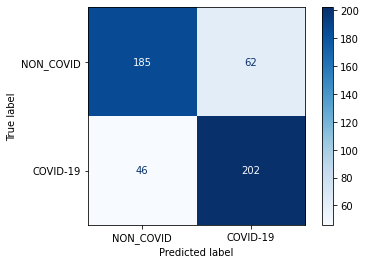

In [18]:
print("[INFO] evaluating Linear SVM on raw pixel accuracy...")
linear_svc = svm.SVC(kernel='linear')
results.append(benchmark(linear_svc, 'Linear SVM on Raw Pixels'))

### Train and evaluate an SVM classifer using the RBF kernel on the raw pixel intensities

#### 1) using C parameter = 10

[INFO] evaluating RBF SVM raw pixel accuracy with C=10...
________________________________________________________________________________
Training: 
SVC(C=10)
train time: 17.549s
test time:  3.195s

Train Accuracy: 1.000
Test Accuracy: 0.956


classification report:
              precision    recall  f1-score   support

    COVID-19       0.96      0.95      0.96       248
   NON_COVID       0.95      0.96      0.96       247

    accuracy                           0.96       495
   macro avg       0.96      0.96      0.96       495
weighted avg       0.96      0.96      0.96       495

confusion matrix:
[[236  12]
 [ 10 237]]


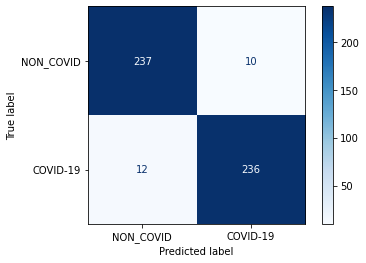

In [19]:
print("[INFO] evaluating RBF SVM raw pixel accuracy with C=10...")
rbf_svc = svm.SVC(kernel='rbf', C = 10, gamma = 'scale')
results.append(benchmark(rbf_svc, 'RBF SVM with C=10 on Raw Pixels'))

#### 2) using C parameter = 1

[INFO] evaluating RBF SVM on raw pixel accuracy with C=1...
________________________________________________________________________________
Training: 
SVC(C=1)
train time: 15.974s
test time:  3.154s

Train Accuracy: 0.981
Test Accuracy: 0.919


classification report:
              precision    recall  f1-score   support

    COVID-19       0.94      0.90      0.92       248
   NON_COVID       0.90      0.94      0.92       247

    accuracy                           0.92       495
   macro avg       0.92      0.92      0.92       495
weighted avg       0.92      0.92      0.92       495

confusion matrix:
[[223  25]
 [ 15 232]]


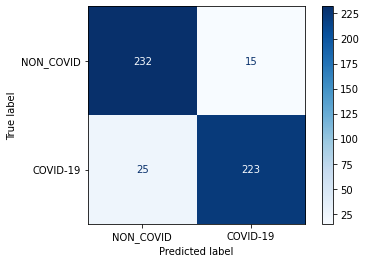

In [20]:
print("[INFO] evaluating RBF SVM on raw pixel accuracy with C=1...")
rbf_svc = svm.SVC(kernel='rbf', C = 1, gamma = 'scale')
results.append(benchmark(rbf_svc, 'RBF SVM with C=1 on Raw Pixels'))

#### 3) using C parameter = 0.1

[INFO] evaluating RBF SVM on raw pixel accuracy with C=0.1...
________________________________________________________________________________
Training: 
SVC(C=0.1)
train time: 16.660s
test time:  4.962s

Train Accuracy: 0.832
Test Accuracy: 0.794


classification report:
              precision    recall  f1-score   support

    COVID-19       0.86      0.70      0.77       248
   NON_COVID       0.75      0.89      0.81       247

    accuracy                           0.79       495
   macro avg       0.80      0.79      0.79       495
weighted avg       0.80      0.79      0.79       495

confusion matrix:
[[174  74]
 [ 28 219]]


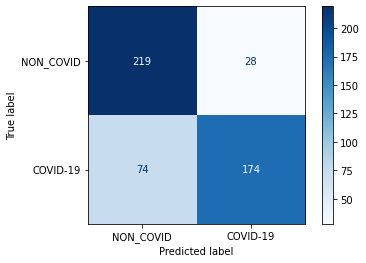

In [21]:
print("[INFO] evaluating RBF SVM on raw pixel accuracy with C=0.1...")
rbf_svc = svm.SVC(kernel='rbf', C = 0.1, gamma = 'scale')
results.append(benchmark(rbf_svc, 'RBF SVM with C=0.1 on Raw Pixels'))

### Train and evaluate a Random Forest Classifier on the raw pixel intensities

[INFO] evaluating Random Forest on raw pixel accuracy...
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 7.666s
test time:  0.043s

Train Accuracy: 1.000
Test Accuracy: 0.901


classification report:
              precision    recall  f1-score   support

    COVID-19       0.94      0.85      0.90       248
   NON_COVID       0.87      0.95      0.91       247

    accuracy                           0.90       495
   macro avg       0.90      0.90      0.90       495
weighted avg       0.90      0.90      0.90       495

confusion matrix:
[[212  36]
 [ 13 234]]


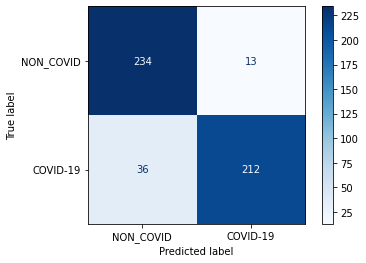

In [22]:
print("[INFO] evaluating Random Forest on raw pixel accuracy...")
rfc = RandomForestClassifier()
results.append(benchmark(rfc, 'Random Forest on Raw Pixels'))

### Train and evaluate a Voting Classifier with hard voting on the raw pixel intensities

[INFO] evaluating Voting Classifier on raw pixel accuracy...
________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('1', KNeighborsClassifier(n_neighbors=3)),
                             ('2', SVC(C=10)),
                             ('3', RandomForestClassifier())])
train time: 26.120s
test time:  12.555s

Train Accuracy: 1.000
Test Accuracy: 0.952


classification report:
              precision    recall  f1-score   support

    COVID-19       0.96      0.95      0.95       248
   NON_COVID       0.95      0.96      0.95       247

    accuracy                           0.95       495
   macro avg       0.95      0.95      0.95       495
weighted avg       0.95      0.95      0.95       495

confusion matrix:
[[235  13]
 [ 11 236]]


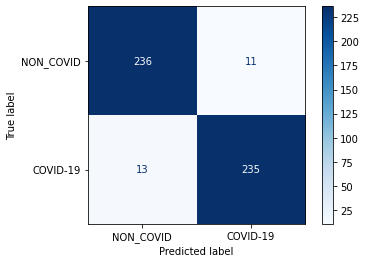

In [23]:
print("[INFO] evaluating Voting Classifier on raw pixel accuracy...")
estimator = []
estimator.append(('1', knn))
estimator.append(('2', svm.SVC(kernel='rbf', C=10, gamma = 'scale')))
estimator.append(('3', rfc))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
results.append(benchmark(vot_hard, 'Voting Classifier on Raw Pixels'))

## B. Training the algorithms using the Color Histogram features

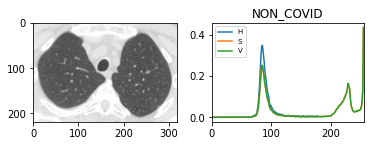

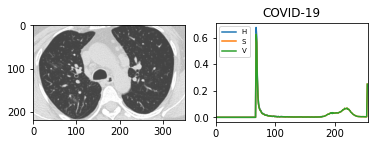

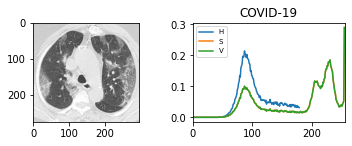

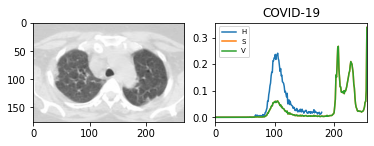

In [24]:
imagePaths = list(paths.list_images("Images-processed/"))
rand = random.choices(imagePaths, k=4)
for (i, rand) in enumerate(rand):
    img = cv2.imread(rand)
    hist_h = cv2.calcHist([img], [0], None, [180], [0, 180])
    hist_s = cv2.calcHist([img], [1], None, [256], [0, 256])
    hist_v = cv2.calcHist([img], [2], None, [256], [0, 256])
    hist_h = cv2.normalize(hist_h, hist_h)
    hist_s = cv2.normalize(hist_s, hist_s)
    hist_v = cv2.normalize(hist_v, hist_v)
    plt.subplot(221), plt.imshow(img, 'gray')
    plt.subplot(222), plt.plot(hist_h, label='H'), 
    plt.plot(hist_s, label='S'), plt.plot(hist_v, label='V'), plt.xlim(0, 256), 
    plt.legend(loc=2, prop={'size': 7})
    label = rand.split(os.path.sep)[-1].split(".")[0]
    plt.title(label)
    plt.show()

### Specify the inputs

In [25]:
X = histogram
y = labels
X_train = trainFeat
X_test = testFeat
y_train = trainLabels
y_test = testLabels

### Perform standardization by centering and scaling the training set and the test set

In [26]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Find the best k to use for the k-NN classifier

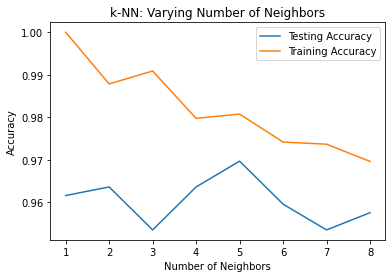

In [27]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Train and evaluate a k-NN classifer on the color histogram representations

[INFO] evaluating k-NN on color histogram accuracy...
________________________________________________________________________________
Training: 
KNeighborsClassifier()
train time: 0.190s
test time:  1.974s

Train Accuracy: 0.981
Test Accuracy: 0.970


classification report:
              precision    recall  f1-score   support

    COVID-19       0.96      0.98      0.97       248
   NON_COVID       0.98      0.96      0.97       247

    accuracy                           0.97       495
   macro avg       0.97      0.97      0.97       495
weighted avg       0.97      0.97      0.97       495

confusion matrix:
[[243   5]
 [ 10 237]]


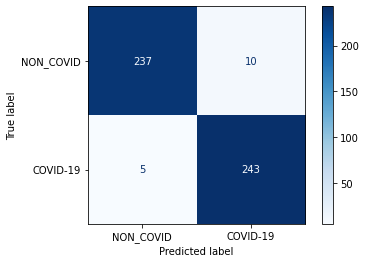

In [28]:
print("[INFO] evaluating k-NN on color histogram accuracy...")
knn = KNeighborsClassifier(n_neighbors=5)
results.append(benchmark(knn, 'k-NN on Color Histograms'))

### Train and evaluate a Linear SVM classifer on the color histogram representations

[INFO] evaluating Linear SVM color histogram accuracy...
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 1.608s
test time:  0.177s

Train Accuracy: 0.941
Test Accuracy: 0.889

dimensionality: 692
density: 0.384393

classification report:
              precision    recall  f1-score   support

    COVID-19       0.94      0.83      0.88       248
   NON_COVID       0.85      0.95      0.89       247

    accuracy                           0.89       495
   macro avg       0.89      0.89      0.89       495
weighted avg       0.89      0.89      0.89       495

confusion matrix:
[[206  42]
 [ 13 234]]


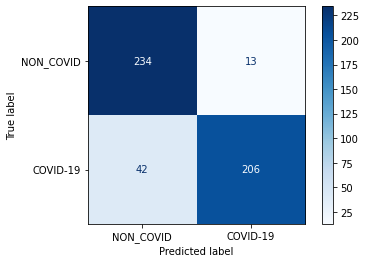

In [29]:
print("[INFO] evaluating Linear SVM color histogram accuracy...")
linear_svc = svm.SVC(kernel='linear')
results.append(benchmark(linear_svc, 'Linear SVM on Color Histograms'))

### Perform GridSearchCV to find the best RBF kernel parameters for an SVM model

#### Train and evaluate an RBF SVM classifer on the color histogram representations and print the classification report for the model

In [30]:
svc = svm.SVC()

# Specify the hyperparameter space
parameters = {'C':[0.1, 1, 10, 100],
              'gamma':[0.1, 1, 10, 'scale']}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(svc, parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Tuned Model Parameters: {}".format(cv.best_params_))

Tuned Model Parameters: {'C': 100, 'gamma': 'scale'}


[INFO] evaluating RBF SVM on color histogram with Tuned Model Parameters...
________________________________________________________________________________
Training: 
SVC(C=100)
train time: 0.807s
test time:  0.150s

Train Accuracy: 1.000
Test Accuracy: 0.949


classification report:
              precision    recall  f1-score   support

    COVID-19       0.95      0.95      0.95       248
   NON_COVID       0.95      0.95      0.95       247

    accuracy                           0.95       495
   macro avg       0.95      0.95      0.95       495
weighted avg       0.95      0.95      0.95       495

confusion matrix:
[[235  13]
 [ 12 235]]


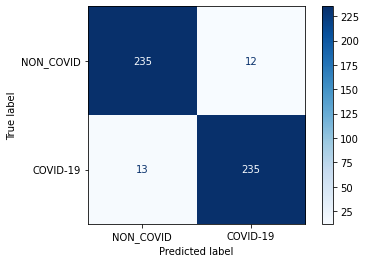

In [31]:
print("[INFO] evaluating RBF SVM on color histogram with Tuned Model Parameters...")
rbf_svc = svm.SVC(kernel='rbf', C = 100, gamma = 'scale')
results.append(benchmark(rbf_svc, 'RBF SVM on Color Histograms'))

### Train and evaluate a Random Forest Classifier

[INFO] evaluating Random Forest on color histogram accuracy...
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 1.555s
test time:  0.029s

Train Accuracy: 1.000
Test Accuracy: 0.941


classification report:
              precision    recall  f1-score   support

    COVID-19       0.96      0.92      0.94       248
   NON_COVID       0.92      0.96      0.94       247

    accuracy                           0.94       495
   macro avg       0.94      0.94      0.94       495
weighted avg       0.94      0.94      0.94       495

confusion matrix:
[[228  20]
 [  9 238]]


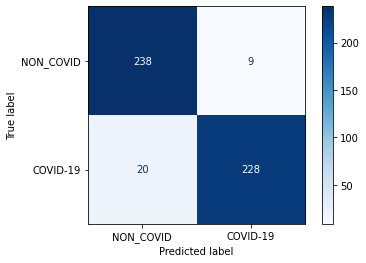

In [32]:
print("[INFO] evaluating Random Forest on color histogram accuracy...")
rfc = RandomForestClassifier()
results.append(benchmark(rfc, 'Random Forest on Color Histograms'))

### Train and evaluate a Voting Classifier with hard voting on the Color Histogram features

[INFO] evaluating Voting Classifier on color histogram accuracy...
________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('1', KNeighborsClassifier()), ('2', SVC(C=100)),
                             ('3', RandomForestClassifier())])
train time: 2.051s
test time:  1.389s

Train Accuracy: 1.000
Test Accuracy: 0.962


classification report:
              precision    recall  f1-score   support

    COVID-19       0.97      0.96      0.96       248
   NON_COVID       0.96      0.97      0.96       247

    accuracy                           0.96       495
   macro avg       0.96      0.96      0.96       495
weighted avg       0.96      0.96      0.96       495

confusion matrix:
[[237  11]
 [  8 239]]


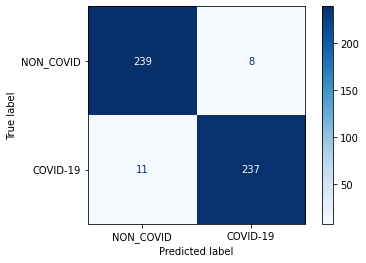

In [33]:
print("[INFO] evaluating Voting Classifier on color histogram accuracy...")
estimator = []
estimator.append(('1', knn))
estimator.append(('2', rbf_svc))
estimator.append(('3', rfc))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
results.append(benchmark(vot_hard, 'Voting Classifier on Color Histograms'))

## C. Training the algorithms using the Haralick Texture features

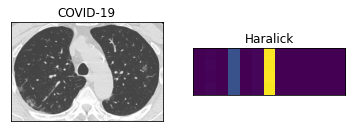

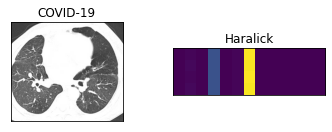

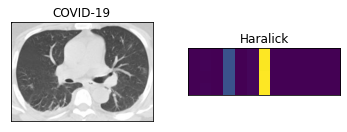

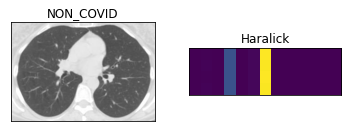

In [34]:
imagePaths = list(paths.list_images("Images-processed/"))
rand = random.choices(imagePaths, k=4)
for (i, rand) in enumerate(rand):
    img = cv2.imread(rand)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray)
    plt.subplot(2,2,1),plt.imshow(img, cmap = 'gray')
    label = rand.split(os.path.sep)[-1].split(".")[0]
    plt.title(label), plt.xticks([]), plt.yticks([])
    plt.subplot(2,2,2),plt.imshow(haralick)
    plt.title('Haralick'), plt.xticks([]), plt.yticks([])
    plt.show()

### Specify the inputs

In [35]:
X = hara
y = labels
X_train = trainHara
X_test = testHara
y_train = trainHaraL
y_test = testHaraL

### Perform standardization by centering and scaling the training set and the test set

In [36]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Find the best k to use for the k-NN classifier

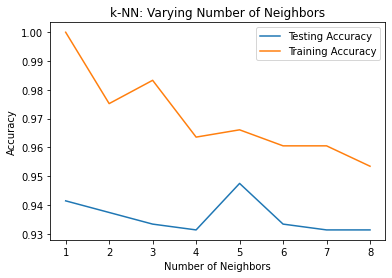

In [37]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Train and evaluate a k-NN classifer on the Haralick Texture features

[INFO] evaluating k-NN on Haralick Texture accuracy...
________________________________________________________________________________
Training: 
KNeighborsClassifier()
train time: 0.008s
test time:  0.053s

Train Accuracy: 0.966
Test Accuracy: 0.947


classification report:
              precision    recall  f1-score   support

    COVID-19       0.93      0.96      0.95       248
   NON_COVID       0.96      0.93      0.95       247

    accuracy                           0.95       495
   macro avg       0.95      0.95      0.95       495
weighted avg       0.95      0.95      0.95       495

confusion matrix:
[[239   9]
 [ 17 230]]


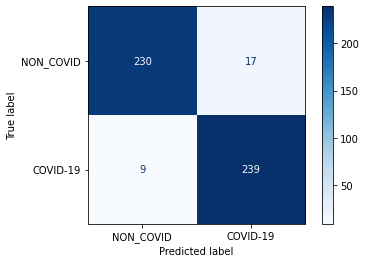

In [38]:
print("[INFO] evaluating k-NN on Haralick Texture accuracy...")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
results.append(benchmark(knn, 'k-NN on Haralick Texture'))

### Train and evaluate a Linear SVM classifer on the Haralick Texture features

[INFO] evaluating Linear SVM on Haralick Texture accuracy...
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 0.121s
test time:  0.008s

Train Accuracy: 0.878
Test Accuracy: 0.855

dimensionality: 13
density: 1.000000

classification report:
              precision    recall  f1-score   support

    COVID-19       0.88      0.82      0.85       248
   NON_COVID       0.83      0.89      0.86       247

    accuracy                           0.85       495
   macro avg       0.86      0.85      0.85       495
weighted avg       0.86      0.85      0.85       495

confusion matrix:
[[204  44]
 [ 28 219]]


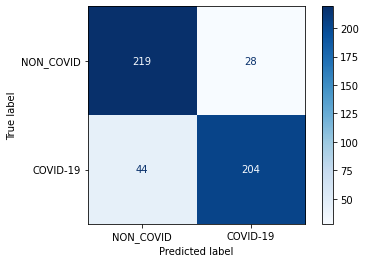

In [39]:
print("[INFO] evaluating Linear SVM on Haralick Texture accuracy...")
linear_svc = svm.SVC(kernel='linear')
results.append(benchmark(linear_svc, 'Linear SVM on Haralick Texture'))

### Perform GridSearchCV to find the best RBF kernel parameters for an SVM model

#### Train and evaluate an RBF SVM classifer on the Haralick Texture features and print the classification report for the model

In [40]:
svc = svm.SVC()

# Specify the hyperparameter space
parameters = {'C':[0.1, 1, 10, 100],
              'gamma':[0.1, 1, 10, 'scale']}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(svc, parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Tuned Model Parameters: {}".format(cv.best_params_))

Tuned Model Parameters: {'C': 100, 'gamma': 1}


[INFO] evaluating RBF SVM on Haralick Texture with Tuned Model Parameters...
________________________________________________________________________________
Training: 
SVC(C=100, gamma=1)
train time: 0.075s
test time:  0.007s

Train Accuracy: 0.998
Test Accuracy: 0.945


classification report:
              precision    recall  f1-score   support

    COVID-19       0.95      0.94      0.95       248
   NON_COVID       0.94      0.95      0.95       247

    accuracy                           0.95       495
   macro avg       0.95      0.95      0.95       495
weighted avg       0.95      0.95      0.95       495

confusion matrix:
[[233  15]
 [ 12 235]]


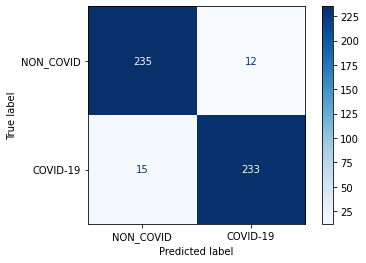

In [41]:
print("[INFO] evaluating RBF SVM on Haralick Texture with Tuned Model Parameters...")
rbf_svc = svm.SVC(kernel='rbf', C = 100, gamma = 1)
results.append(benchmark(rbf_svc, 'RBF SVM on Haralick Texture'))

### Train and evaluate a Random Forest Classifier on the Haralick Texture representations

[INFO] evaluating Random Forest on Haralick Texture accuracy...
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 0.352s
test time:  0.012s

Train Accuracy: 1.000
Test Accuracy: 0.931


classification report:
              precision    recall  f1-score   support

    COVID-19       0.93      0.93      0.93       248
   NON_COVID       0.93      0.93      0.93       247

    accuracy                           0.93       495
   macro avg       0.93      0.93      0.93       495
weighted avg       0.93      0.93      0.93       495

confusion matrix:
[[231  17]
 [ 17 230]]


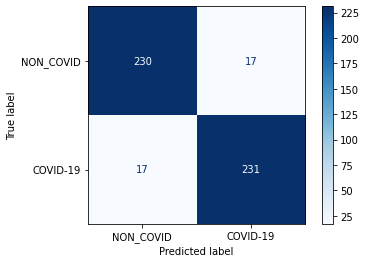

In [42]:
print("[INFO] evaluating Random Forest on Haralick Texture accuracy...")
#Train Random Forest Classifer using default parameters
rfc = RandomForestClassifier()
results.append(benchmark(rfc, 'Random Forest on Haralick Texture'))

### Train and evaluate a Voting Classifier with hard voting on the Haralick Texture representations

[INFO] evaluating Voting Classifier on Haralick Texture...
________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('1', KNeighborsClassifier()),
                             ('2', SVC(C=100, gamma=1)),
                             ('3', RandomForestClassifier())])
train time: 0.420s
test time:  0.039s

Train Accuracy: 0.998
Test Accuracy: 0.947


classification report:
              precision    recall  f1-score   support

    COVID-19       0.94      0.95      0.95       248
   NON_COVID       0.95      0.94      0.95       247

    accuracy                           0.95       495
   macro avg       0.95      0.95      0.95       495
weighted avg       0.95      0.95      0.95       495

confusion matrix:
[[236  12]
 [ 14 233]]


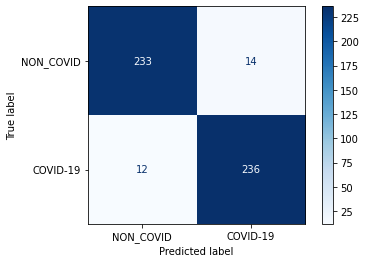

In [43]:
print("[INFO] evaluating Voting Classifier on Haralick Texture...")
start_time = time()
estimator = []
estimator.append(('1', knn))
estimator.append(('2', svm.SVC(kernel='rbf', C=100, gamma = 1)))
estimator.append(('3', rfc))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
results.append(benchmark(vot_hard, 'Voting Classifier on Haralick Texture'))

## D. Training the algorithms using Threshold Adjacency Statistics

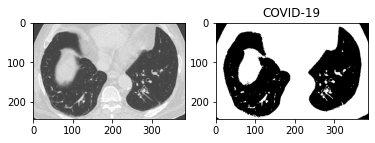

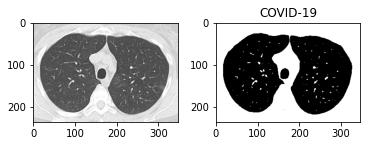

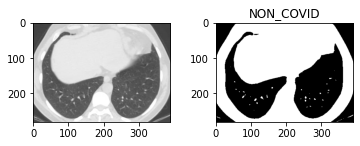

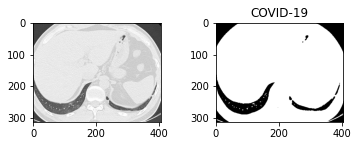

In [44]:
imagePaths = list(paths.list_images("Images-processed/"))
rand = random.choices(imagePaths, k=4)
for (i, rand) in enumerate(rand):
    img = cv2.imread(rand)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = gray.astype(np.uint8)
    T_rc = mahotas.rc(gray)
    label = rand.split(os.path.sep)[-1].split(".")[0]
    plt.subplot(221), plt.imshow(img, 'gray')
    plt.subplot(222), plt.imshow(gray > T_rc, 'gray'), plt.title(label)
    plt.show()

### Specify the inputs

In [45]:
X = tas
y = labels
X_train = trainTas
X_test = testTas
y_train = trainTasL
y_test = testTasL

### Perform standardization by centering and scaling the training set and the test set

In [46]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Find the best k to use for the k-NN classifier

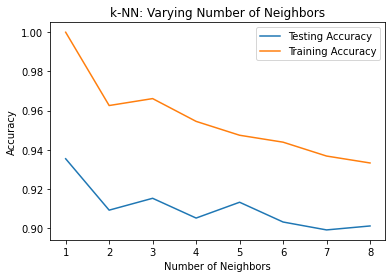

In [47]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Train and evaluate a k-NN classifer on the Threshold Adjacency Statistics (TAS)

[INFO] evaluating k-NN on TAS accuracy...
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=3)
train time: 0.012s
test time:  0.060s

Train Accuracy: 0.966
Test Accuracy: 0.915


classification report:
              precision    recall  f1-score   support

    COVID-19       0.93      0.90      0.91       248
   NON_COVID       0.90      0.94      0.92       247

    accuracy                           0.92       495
   macro avg       0.92      0.92      0.92       495
weighted avg       0.92      0.92      0.92       495

confusion matrix:
[[222  26]
 [ 16 231]]


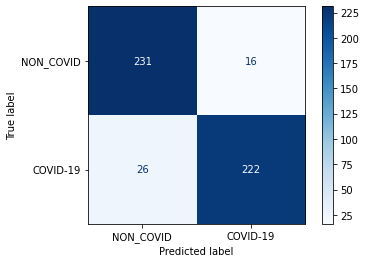

In [48]:
start_time = time()
print("[INFO] evaluating k-NN on TAS accuracy...")
knn = KNeighborsClassifier(n_neighbors=3)
results.append(benchmark(knn, 'k-NN on TAS'))

### Train and evaluate a Linear SVM classifer on the TAS representations

[INFO] evaluating Linear SVM on TAS accuracy...
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 0.143s
test time:  0.016s

Train Accuracy: 0.894
Test Accuracy: 0.853

dimensionality: 54
density: 1.000000

classification report:
              precision    recall  f1-score   support

    COVID-19       0.87      0.83      0.85       248
   NON_COVID       0.83      0.88      0.86       247

    accuracy                           0.85       495
   macro avg       0.85      0.85      0.85       495
weighted avg       0.85      0.85      0.85       495

confusion matrix:
[[205  43]
 [ 30 217]]


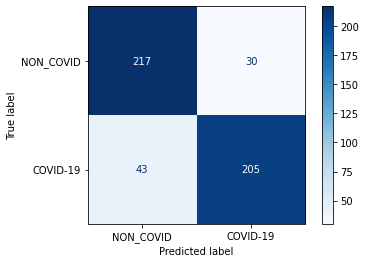

In [49]:
print("[INFO] evaluating Linear SVM on TAS accuracy...")
linear_svc = svm.SVC(kernel='linear')
results.append(benchmark(linear_svc, 'Linear SVM on TAS'))

### Perform GridSearchCV to find the best RBF kernel parameters for an SVM model

#### Train and evaluate an RBF SVM classifer on the TAS representations and print the classification report for the model

In [50]:
svc = svm.SVC()

# Specify the hyperparameter space
parameters = {'C':[0.1, 1, 10, 100],
              'gamma':[0.1, 1, 10, 'scale']}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(svc, parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Tuned Model Parameters: {}".format(cv.best_params_))

Tuned Model Parameters: {'C': 10, 'gamma': 0.1}


[INFO] evaluating RBF SVM on TAS with Tuned Model Parameters...
________________________________________________________________________________
Training: 
SVC(C=10, gamma=0.1)
train time: 0.147s
test time:  0.024s

Train Accuracy: 0.987
Test Accuracy: 0.935


classification report:
              precision    recall  f1-score   support

    COVID-19       0.94      0.93      0.94       248
   NON_COVID       0.93      0.94      0.94       247

    accuracy                           0.94       495
   macro avg       0.94      0.94      0.94       495
weighted avg       0.94      0.94      0.94       495

confusion matrix:
[[231  17]
 [ 15 232]]


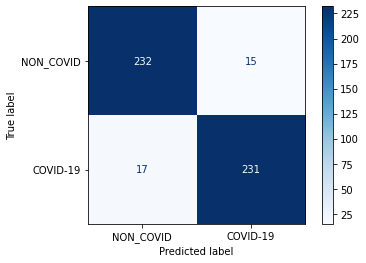

In [51]:
print("[INFO] evaluating RBF SVM on TAS with Tuned Model Parameters...")
rbf_svc = svm.SVC(kernel='rbf', C = 10, gamma = 0.1)
results.append(benchmark(rbf_svc, 'RBF SVM on TAS'))

### Train and evaluate a Random Forest Classifier on the TAS representations

[INFO] evaluating Random Forest on TAS...
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 0.648s
test time:  0.013s

Train Accuracy: 1.000
Test Accuracy: 0.913


classification report:
              precision    recall  f1-score   support

    COVID-19       0.90      0.93      0.91       248
   NON_COVID       0.93      0.90      0.91       247

    accuracy                           0.91       495
   macro avg       0.91      0.91      0.91       495
weighted avg       0.91      0.91      0.91       495

confusion matrix:
[[230  18]
 [ 25 222]]


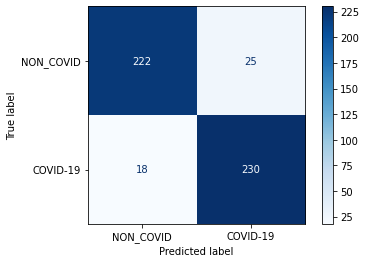

In [52]:
print("[INFO] evaluating Random Forest on TAS...")
#Train Random Forest Classifer using default parameters
rfc = RandomForestClassifier()
results.append(benchmark(rfc, 'Random Forest on TAS'))

### Train and evaluate a Voting Classifier with hard voting on the TAS representations

[INFO] evaluating Voting Classifier on TAS...
________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('1', KNeighborsClassifier(n_neighbors=3)),
                             ('2', SVC(C=10, gamma=0.1)),
                             ('3', RandomForestClassifier())])
train time: 0.797s
test time:  0.086s

Train Accuracy: 0.991
Test Accuracy: 0.943


classification report:
              precision    recall  f1-score   support

    COVID-19       0.95      0.93      0.94       248
   NON_COVID       0.93      0.96      0.94       247

    accuracy                           0.94       495
   macro avg       0.94      0.94      0.94       495
weighted avg       0.94      0.94      0.94       495

confusion matrix:
[[231  17]
 [ 11 236]]


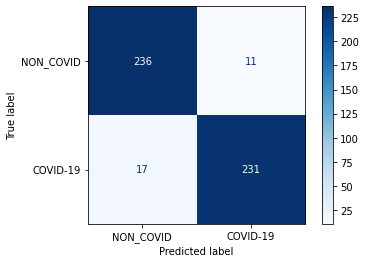

In [53]:
print("[INFO] evaluating Voting Classifier on TAS...")
start_time = time()
estimator = []
estimator.append(('1', knn))
estimator.append(('2', svm.SVC(kernel='rbf', C=10, gamma=0.1)))
estimator.append(('3', rfc))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
results.append(benchmark(vot_hard, 'Voting Classifier on TAS'))

## E. Training the algorithms using all the features (Color Histogram, Haralink, & TAS)

### Specify the inputs

In [54]:
X = features
y = labels
X_train = trainF
X_test = testF
y_train = trainFL
y_test = testFL
results_feat = []

### Perform standardization by centering and scaling the training set and the test set

In [55]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Find the best k to use for the k-NN classifier

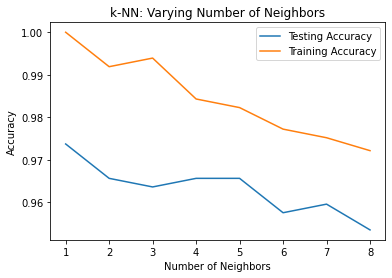

In [56]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Train and evaluate a k-NN classifer on the Features matrix

[INFO] evaluating k-NN on Features accuracy...
________________________________________________________________________________
Training: 
KNeighborsClassifier()
train time: 0.117s
test time:  2.109s

Train Accuracy: 0.982
Test Accuracy: 0.966


classification report:
              precision    recall  f1-score   support

    COVID-19       0.97      0.96      0.97       248
   NON_COVID       0.96      0.97      0.97       247

    accuracy                           0.97       495
   macro avg       0.97      0.97      0.97       495
weighted avg       0.97      0.97      0.97       495

confusion matrix:
[[238  10]
 [  7 240]]


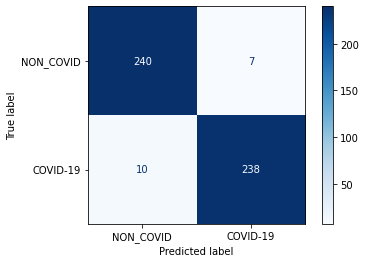

In [57]:
print("[INFO] evaluating k-NN on Features accuracy...")
knn = KNeighborsClassifier(n_neighbors=5) #to avoid overfitting
results.append(benchmark(knn, 'k-NN on Features'))

### Train and evaluate a Linear SVM classifer on the Features matrix

[INFO] evaluating Linear SVM on Features accuracy...
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 1.244s
test time:  0.146s

Train Accuracy: 0.972
Test Accuracy: 0.919

dimensionality: 759
density: 0.438735

classification report:
              precision    recall  f1-score   support

    COVID-19       0.92      0.92      0.92       248
   NON_COVID       0.92      0.92      0.92       247

    accuracy                           0.92       495
   macro avg       0.92      0.92      0.92       495
weighted avg       0.92      0.92      0.92       495

confusion matrix:
[[228  20]
 [ 20 227]]


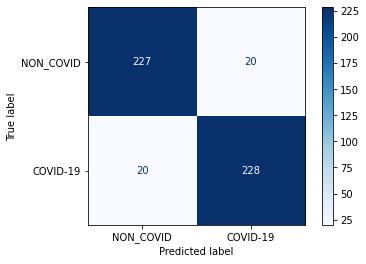

In [58]:
print("[INFO] evaluating Linear SVM on Features accuracy...")
linear_svc = svm.SVC(kernel='linear')
results.append(benchmark(linear_svc, 'Linear SVM on Features'))

### Perform GridSearchCV to find the best RBF kernel parameters for an SVM model

#### Train and evaluate an RBF SVM classifer on the Features matrix and print the classification report for the model

In [59]:
svc = svm.SVC()

# Specify the hyperparameter space
parameters = {'C':[0.1, 1, 100],
              'gamma':[0.1, 1, 10, 'scale']}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(svc, parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Tuned Model Parameters: {}".format(cv.best_params_))

Tuned Model Parameters: {'C': 100, 'gamma': 'scale'}


[INFO] evaluating RBF SVM on Features with Tuned Model Parameters...
________________________________________________________________________________
Training: 
SVC(C=100)
train time: 0.884s
test time:  0.173s

Train Accuracy: 1.000
Test Accuracy: 0.974


classification report:
              precision    recall  f1-score   support

    COVID-19       0.97      0.98      0.97       248
   NON_COVID       0.98      0.97      0.97       247

    accuracy                           0.97       495
   macro avg       0.97      0.97      0.97       495
weighted avg       0.97      0.97      0.97       495

confusion matrix:
[[243   5]
 [  8 239]]


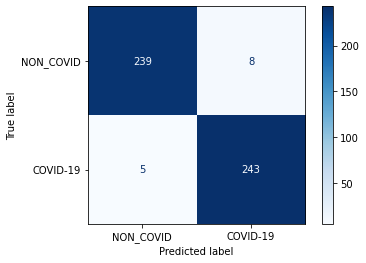

In [60]:
print("[INFO] evaluating RBF SVM on Features with Tuned Model Parameters...")
rbf_svc = svm.SVC(kernel='rbf', C = 100, gamma = 'scale')
results.append(benchmark(rbf_svc, 'RBF SVM on Features'))

### Train and evaluate a Random Forest Classifier on the Features matrix

[INFO] evaluating Random Forest on Features...
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 1.634s
test time:  0.014s

Train Accuracy: 1.000
Test Accuracy: 0.954


classification report:
              precision    recall  f1-score   support

    COVID-19       0.96      0.94      0.95       248
   NON_COVID       0.94      0.96      0.95       247

    accuracy                           0.95       495
   macro avg       0.95      0.95      0.95       495
weighted avg       0.95      0.95      0.95       495

confusion matrix:
[[234  14]
 [  9 238]]


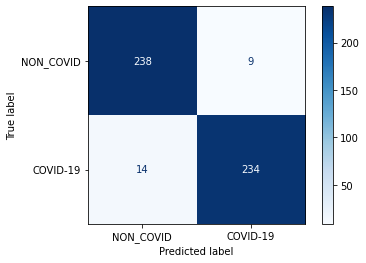

In [61]:
print("[INFO] evaluating Random Forest on Features...")
rfc = RandomForestClassifier()
results.append(benchmark(rfc, 'Random Forest on Features'))

### Train and evaluate a Voting Classifier with hard voting on the Features matrix

________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('1', KNeighborsClassifier()),
                             ('2', SVC(C=100, probability=True)),
                             ('3', RandomForestClassifier())])
train time: 5.641s
test time:  1.540s

Train Accuracy: 1.000
Test Accuracy: 0.984


classification report:
              precision    recall  f1-score   support

    COVID-19       0.98      0.98      0.98       248
   NON_COVID       0.98      0.98      0.98       247

    accuracy                           0.98       495
   macro avg       0.98      0.98      0.98       495
weighted avg       0.98      0.98      0.98       495

confusion matrix:
[[244   4]
 [  4 243]]


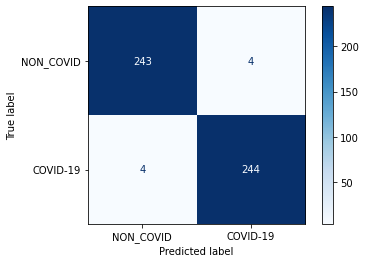

In [77]:
estimator = []
estimator.append(('1', knn))
estimator.append(('2', rbf_svc))
estimator.append(('3', rfc))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
results.append(benchmark(vot_hard, 'Voting Classifier on Features'))

## Benchmark

In [63]:
def scoreof(results):
    indices = np.arange(len(results))
    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results

    x = clf_names
    y = score
    x_pos = [i for i, _ in enumerate(x)]

    fig, ax = plt.subplots(figsize=(15, 10))
    rects1 = ax.bar(x_pos, y, color='b')
    plt.ylabel("Score")
    plt.title("Score")
    plt.xticks(x_pos, x)
    # Turn on the grid
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                    '%f' % float(height),
            ha='center', va='bottom')
    autolabel(rects1)
    plt.show()

In [64]:
def timeof(results, ind):
    indices = np.arange(len(results))
    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results

    training_time = np.array(training_time)
    test_time = np.array(test_time)

    plt.figure(figsize=(15, 15))
    plt.title("Execution Time")
    plt.barh(indices + .3, training_time, .3, label="training time", color='c')
    plt.barh(indices + .6, test_time, .3, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')

    for i, c in zip(indices, clf_names):
        plt.text(ind, i, c)

    plt.show()


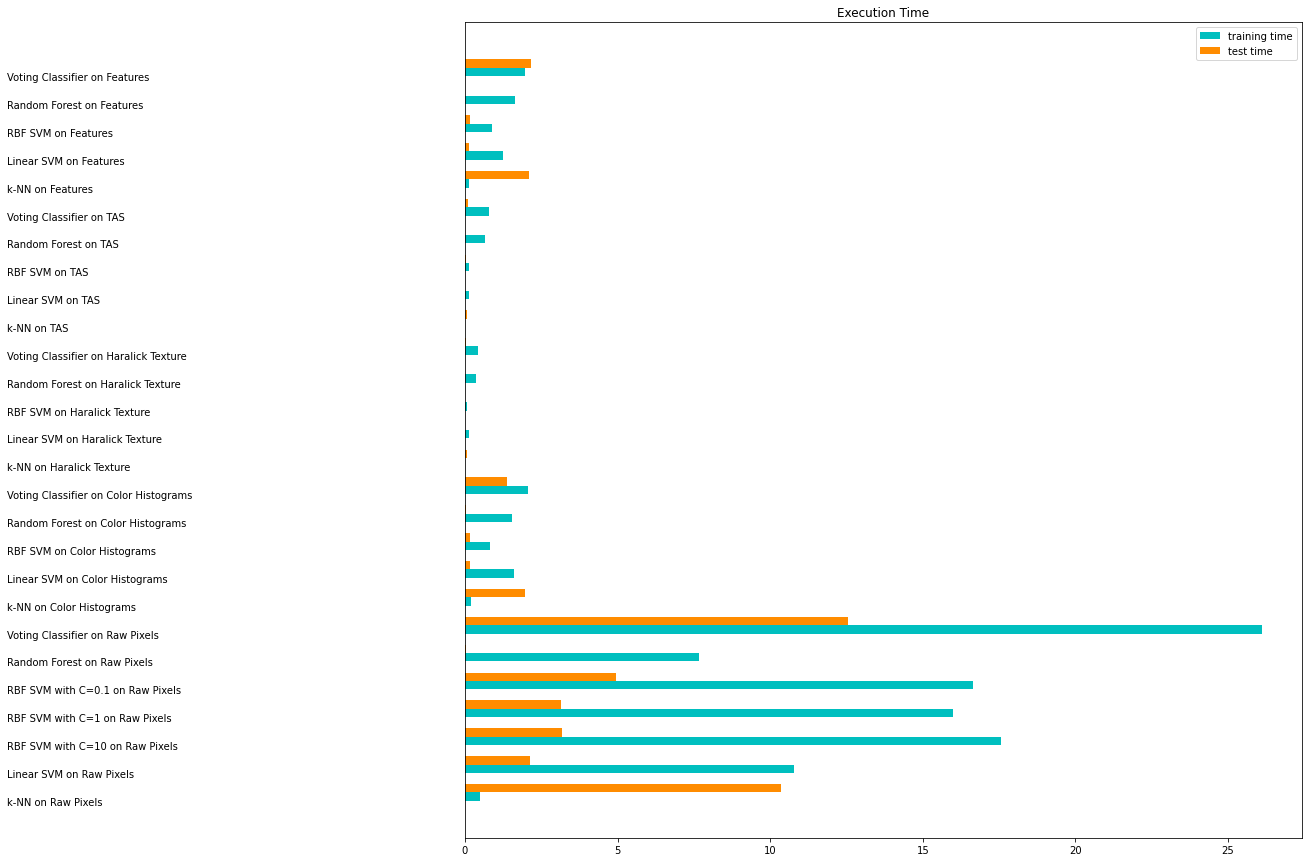

In [65]:
timeof(results, -15)

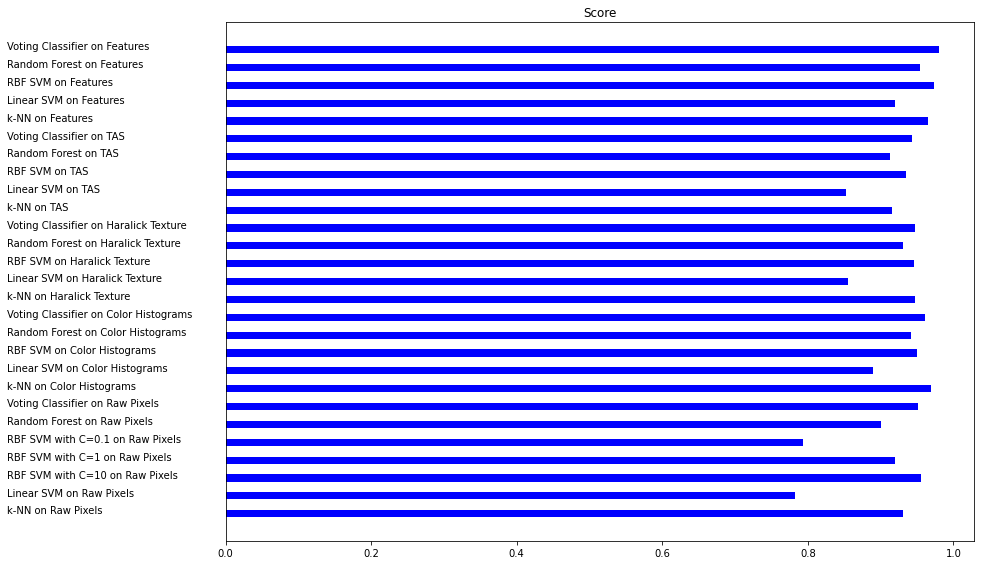

In [66]:
indices = np.arange(len(results))

clf_names, score, training_time, test_time = [[x[i] for x in results] for i in range(4)]

plt.figure(figsize=(16, 8))
plt.title("Score")
plt.barh(indices, score, .4, label="score", color='blue')
plt.yticks(())
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

### Benchmark Features

k-NN
________________________________________________________________________________
Training: 
KNeighborsClassifier()
train time: 0.141s
test time:  2.503s

Train Accuracy: 0.982
Test Accuracy: 0.966


classification report:
              precision    recall  f1-score   support

    COVID-19       0.97      0.96      0.97       248
   NON_COVID       0.96      0.97      0.97       247

    accuracy                           0.97       495
   macro avg       0.97      0.97      0.97       495
weighted avg       0.97      0.97      0.97       495

confusion matrix:
[[238  10]
 [  7 240]]


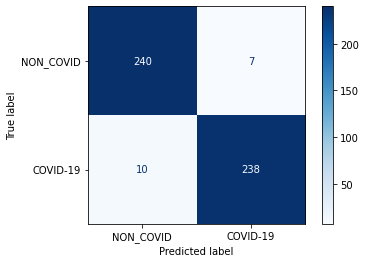


Linear SVM
________________________________________________________________________________
Training: 
SVC(kernel='linear')
train time: 1.436s
test time:  0.311s

Train Accuracy: 0.972
Test Accuracy: 0.919

dimensionality: 759
density: 0.438735

classification report:
              precision    recall  f1-score   support

    COVID-19       0.92      0.92      0.92       248
   NON_COVID       0.92      0.92      0.92       247

    accuracy                           0.92       495
   macro avg       0.92      0.92      0.92       495
weighted avg       0.92      0.92      0.92       495

confusion matrix:
[[228  20]
 [ 20 227]]


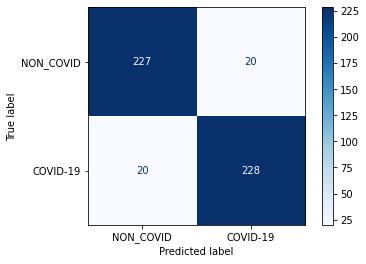


RBF SVM
________________________________________________________________________________
Training: 
SVC(C=100)
train time: 0.876s
test time:  0.170s

Train Accuracy: 1.000
Test Accuracy: 0.974


classification report:
              precision    recall  f1-score   support

    COVID-19       0.97      0.98      0.97       248
   NON_COVID       0.98      0.97      0.97       247

    accuracy                           0.97       495
   macro avg       0.97      0.97      0.97       495
weighted avg       0.97      0.97      0.97       495

confusion matrix:
[[243   5]
 [  8 239]]


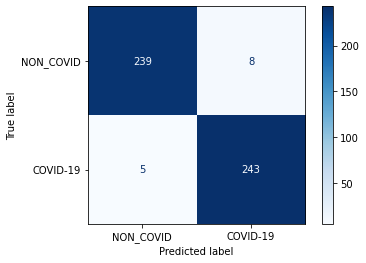


Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 1.002s
test time:  0.014s

Train Accuracy: 1.000
Test Accuracy: 0.966


classification report:
              precision    recall  f1-score   support

    COVID-19       0.97      0.96      0.97       248
   NON_COVID       0.96      0.97      0.97       247

    accuracy                           0.97       495
   macro avg       0.97      0.97      0.97       495
weighted avg       0.97      0.97      0.97       495

confusion matrix:
[[238  10]
 [  7 240]]


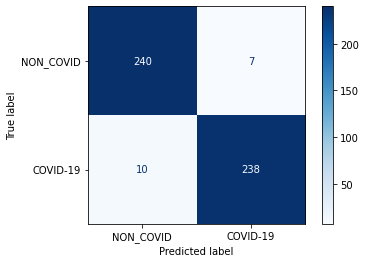


Voting Classifier
________________________________________________________________________________
Training: 
VotingClassifier(estimators=[('1', KNeighborsClassifier()), ('2', SVC(C=100)),
                             ('3', RandomForestClassifier())])
train time: 3.097s
test time:  1.539s

Train Accuracy: 1.000
Test Accuracy: 0.978


classification report:
              precision    recall  f1-score   support

    COVID-19       0.98      0.97      0.98       248
   NON_COVID       0.97      0.98      0.98       247

    accuracy                           0.98       495
   macro avg       0.98      0.98      0.98       495
weighted avg       0.98      0.98      0.98       495

confusion matrix:
[[241   7]
 [  4 243]]


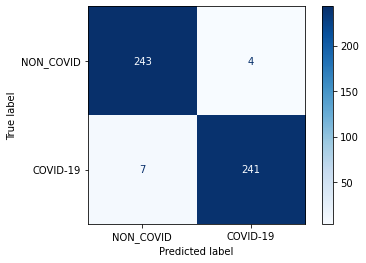

In [67]:
results_feat = []
for clf, name in (
        (knn, "k-NN"),
        (linear_svc, "Linear SVM"),
        (rbf_svc, "RBF SVM"),
        (rfc, "Random Forest"),
        (vot_hard, "Voting Classifier")):
    print('=' * 80)
    print(name)
    results_feat.append(benchmark(clf, name))


print('=' * 80)
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.

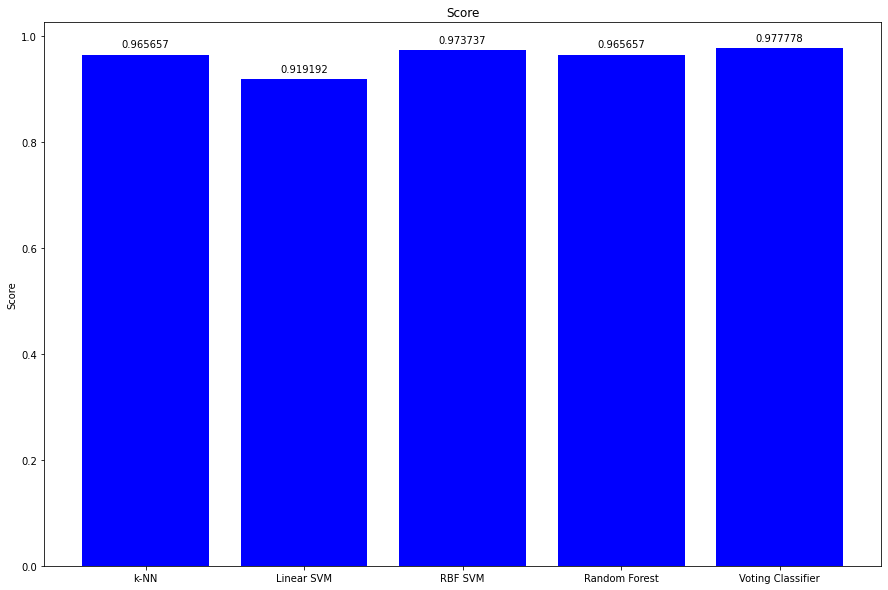

In [68]:
scoreof(results_feat)

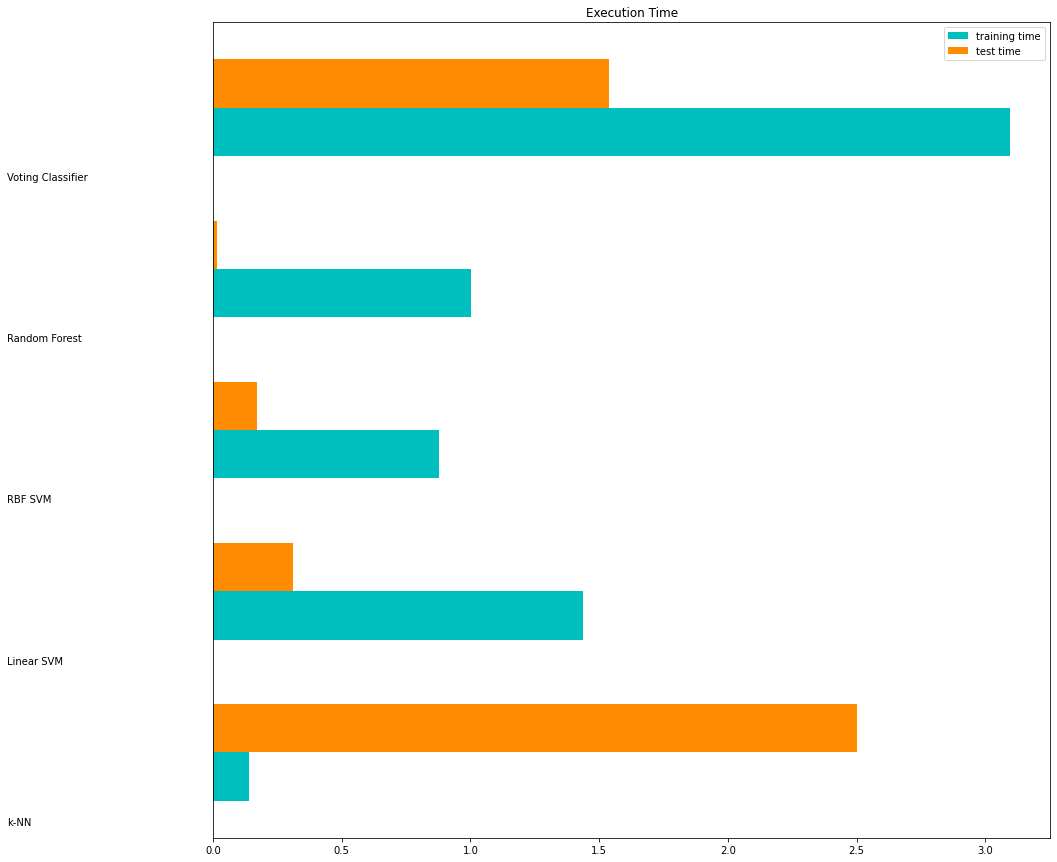

In [69]:
timeof(results_feat, -0.8)

## Further method:

### Train and evaluate a Multi-layer Perceptron classifier on the Features matrix

[INFO] evaluating MLPClassifier on Features...
________________________________________________________________________________
Training: 
MLPClassifier(hidden_layer_sizes=500)
train time: 23.941s
test time:  0.013s

Train Accuracy: 1.000
Test Accuracy: 0.978


classification report:
              precision    recall  f1-score   support

    COVID-19       0.99      0.97      0.98       248
   NON_COVID       0.97      0.99      0.98       247

    accuracy                           0.98       495
   macro avg       0.98      0.98      0.98       495
weighted avg       0.98      0.98      0.98       495

confusion matrix:
[[240   8]
 [  3 244]]


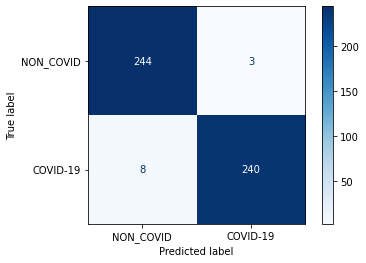

In [70]:
print("[INFO] evaluating MLPClassifier on Features...")
start_time = time()
mlp = MLPClassifier(hidden_layer_sizes=500)
results_feat.append(benchmark(mlp, 'MLPClassifier'))

## Anvil App

In [71]:
print("[INFO] Building Anvil app...")
t0 = time()
X = features
y = labels
X_train = trainF
X_test = testF
y_train = trainFL
y_test = testFL
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)
linear_svc = svm.SVC(kernel='linear', probability=True)
linear_svc.fit(X_train, y_train)
rbf_svc = svm.SVC(kernel='rbf', C = 100, gamma = 'scale', probability=True)
rbf_svc.fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
mlp = MLPClassifier(hidden_layer_sizes=500)
mlp.fit(X_train, y_train)
estimator = []
estimator.append(('1', knn))
estimator.append(('2', rbf_svc))
estimator.append(('3', rfc))
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_train, y_train)
train_time = time() - t0
print("train time: %0.3fs" % train_time)

[INFO] Building Anvil app...
train time: 50.938s


In [72]:
import anvil.server
anvil.server.connect("3YPAFQMZCK7HF3I4K2LTMRLD-XLRLG4JQYH74F4SS")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment (dev)" as SERVER


In [ ]:
import anvil.media

@anvil.server.callable
def classify_image(file):
    with anvil.media.TempFile(file) as filename:
        img = cv2.imread(filename)
    histogram_imp = []
    hara_imp = []
    tas_imp = []
    labels_imp = []
    features_imp = []

    histogram_imp.append(extract_color_histogram(img))
    tas_imp.append(fd_tas(img))
    hara_imp.append(fd_haralick(img))

    histogram_imp = np.array(histogram_imp)
    hara_imp = np.array(hara_imp)
    tas_imp = np.array(tas_imp)
    features_imp = np.concatenate((hara_imp, tas_imp), axis=1)
    features_imp = np.concatenate((features_imp, histogram_imp), axis=1)

    X_pred = features_imp
    X_pred = sc.transform(X_pred)

    return('k-NN Probability of COVID-19: {:.2f}%'.format(knn.predict_proba(X_pred)[0][0]*100) +
            '\nSVM Probability of COVID-19: {:.2f}%'.format(rbf_svc.predict_proba(X_pred)[0][0]*100) +
            '\nLinearSVC Probability of COVID-19: {:.2f}%'.format(linear_svc.predict_proba(X_pred)[0][0]*100) +
            '\nRandom Forest Probability of COVID-19: {:.2f}%'.format(rfc.predict_proba(X_pred)[0][0]*100) +
            '\nMLP Probability of COVID-19: {:.2f}%'.format(mlp.predict_proba(X_pred)[0][0]*100) +
            '\nVoting Classifier of kNN, SVM, & RF with Hard Voting Result: {}'.format(vot_hard.predict(X_pred)[0]))

anvil.server.wait_forever()

### Now go to https://XLRLG4JQYH74F4SS.anvil.app/VMNA2YYY6MBAPGAFDPMDIOIW and upload a CT Scan image. For optimum results used a cropped image that looks like this

In [ ]:
anvil.server.disconnect()